In [48]:
# 전역 변수 설정
FILE_SAVE_DIR = './' #있다면 추가 해주기 (상대경로)
line_color_list = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
                    'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white',
                    'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] 

In [49]:
import pandas as pd
import numpy as np
from csv import reader
from numpy import linalg as la
from sys import exit
from haversine import haversine
import math
from operator import itemgetter

#시각화 도구
import folium
from folium.features import DivIcon
import random
import matplotlib.pyplot as plt

In [50]:
# Global Variable Setting

# Nicname = '5CAC8432AE4EC54B'
# Huzzi = '44754E5A077F32B4'
# oizi = '2DDB3706DE4F7B45'
kyounghwan = '3963650B38CAF112'

ryeong = '72294652E731441B'
soo = '29D97405E68FA578'

PATIENT_UID = kyounghwan # 감염자 UID
TARGET_UID =  Huzzi # 조사 대상자 UID

# Map Setting
Raw_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
Filter_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
mass_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사
compare_map = folium.Map(location = [37.5505938572,127.074236903], zoom_start =100) # 세종대학교 중심 조사


In [51]:
#Call CSV file
def load_GPS_set(UID): # Data load
    try:
        data_set = pd.read_csv(FILE_SAVE_DIR + UID +"_gps"+".csv", sep=",", dtype='unicode')
        data_set['TIME STAMP'] = pd.to_datetime(data_set['LOG TIME']).dt.strftime('%Y-%m-%d %H:%M:%s')
        # data_set['TIME'] = data_set['TIME STAMP'].dt.strftime('%Y-%m-%d %H:%M') # 초단위 자르기
        # data_set['STAMP_TIME'] = pd.to_datetime(data_set['TIME']) # stamp_time datetime 형식으로 변경
        re_data_set = data_set[["TIME STAMP","UID","altitude","latitude","longitude","provider"]]
        return re_data_set
    
    except FileNotFoundError as e:
        pass
def load_Sateillate_set(UID): # Data load
    try:
        data_set = pd.read_csv(FILE_SAVE_DIR + UID +"_sate"+".csv", sep=",", dtype='unicode')
        data_set['TIME STAMP'] = pd.to_datetime(data_set['LOG TIME']).dt.strftime('%Y-%m-%d %H:%M:%s')
        # data_set['TIME'] = data_set['TIME STAMP'].dt.strftime('%Y-%m-%d %H:%M') # 초단위 자르기
        # data_set['STAMP_TIME'] = pd.to_datetime(data_set['TIME']) # stamp_time datetime 형식으로 변경
        re_data_set = data_set[["TIME STAMP","UID","SNR AVERAGE","SATELLITE COUNT"]]
        return re_data_set
    
    except FileNotFoundError as e:
        pass

def merge_gps_sati_set(UID): # for weight_filter
    merge_df = pd.merge(load_GPS_set(UID),load_Sateillate_set(UID), how='left', on = ['TIME STAMP','UID'])
    return merge_df

################### RAW DATA FUNC ######################
def extract_raw_data(UID,start,end):
    Dataframe = merge_gps_sati_set(UID)
    marker_list = []
    for count in range(start,end):
        marker_point_lati = float(Dataframe.loc[count,'latitude'])
        marker_point_long = float(Dataframe.loc[count,'longitude'])
        marker_point_time = Dataframe.loc[count,'TIME STAMP']
        marker_point = [marker_point_time, marker_point_lati, marker_point_long]
        marker_list.append(marker_point)
    return marker_list
    
################### ABOUT MAP DROWING FUNC #####################
def draw_Polyline_map(map, marker_list, draw_color):
    replace_list = []
    for marker_point in marker_list:
        replace_list.append(marker_point[1:3])
    folium.PolyLine(locations=replace_list,tooltip='Polyline',color=draw_color).add_to(map)

def draw_index_map(map, marker_list):
    count = len(marker_list)
    for marker_point in marker_list:
        folium.Marker(marker_point[1:3], icon=DivIcon(icon_size=(10,3),icon_anchor=(7,20),
        html='<div style="font-size: 10pt; color : black">'+str(count)+'</div>',
        )).add_to(map)
        count = count - 1

def draw_circle_map(map, marker_list,draw_radius,draw_color):
    for marker_point in marker_list:
        folium.CircleMarker(location=marker_point[1:3], radius=draw_radius, color= draw_color).add_to(map)


In [52]:
# Huzzi_raw = extract_raw_data(Huzzi,1,321)
# draw_Polyline_map(Raw_map,Huzzi_raw,line_color_list[1])
# draw_index_map(Raw_map,Huzzi_raw)

# joung_raw = extract_raw_data(joungho,100,477)
# draw_Polyline_map(Raw_map,joung_raw,line_color_list[1])
# draw_index_map(Raw_map,joung_raw)

# oizi_raw = extract_raw_data(oizi,1,367)
# draw_Polyline_map(Raw_map,oizi_raw,line_color_list[2])
# # draw_index_map(Raw_map,oizi_raw)

soo_raw = extract_raw_data(soo,1,517)
draw_Polyline_map(Raw_map,soo_raw,line_color_list[1])
# draw_index_map(Raw_map,joung_raw)

ryeong_raw = extract_raw_data(ryeong,1,314)
draw_Polyline_map(Raw_map,ryeong_raw,line_color_list[0])

kyoung_raw = extract_raw_data(kyounghwan,1,516)
draw_Polyline_map(Raw_map,kyoung_raw,line_color_list[3])
# draw_index_map(Raw_map,kyoung_raw)
Raw_map

In [53]:
CLUSTER_SIZE = 12
CHANGE_WEIGHT = 2
WAIT_CHANGE_TIME = 3 #(min)

def calculate_mass_point(cluster_list, CLUSTER_SIZE):
    sum_point_start_time = cluster_list[0][0]
    sum_point_x = 0
    sum_point_y = 0
    for idx in range(0,CLUSTER_SIZE):
        sum_point_x += cluster_list[idx][1]
        sum_point_y += cluster_list[idx][2]
    mass_point = [sum_point_start_time, sum_point_x/CLUSTER_SIZE, sum_point_y/CLUSTER_SIZE]
    return mass_point

def calculate_speed_vector(mass_list):
    vector_start_time = mass_list[len(mass_list)-1][0]
    speed_vector_x = mass_list[len(mass_list)-2][1] - mass_list[len(mass_list)-1][1]
    speed_vector_y = mass_list[len(mass_list)-2][2] - mass_list[len(mass_list)-1][2]
    speed_vector = [vector_start_time,speed_vector_x,speed_vector_y]
    return speed_vector

def calculate_vector_norm(vector):
    norm_time = vector[0]
    norm = math.sqrt(math.pow(vector[1],2)+math.pow(vector[2],2))
    norm_point = [norm_time, norm]
    return norm_point

def replace_point(next, current, previous):
    current[1] = previous[1] + next[1]
    current[2] = previous[2] + next[2]
    return current

def check_inlist_element(list):
    if len(list) > 1:
        return True
    else :
        return False

def compare_vector_norm(vector_list):
    current = calculate_vector_norm(vector_list[len(vector_list)-1])
    previous = calculate_vector_norm(vector_list[len(vector_list)-2])
    change_check(current,previous)

def change_check(current, previous):
    isChange = current >= CHANGE_WEIGHT * previous
    if isChange:
        return True
    else:
        return False  

def speed_vec_filtering(raw_list):
    cluster_list = []
    mass_list = []
    speed_vector_list = []
    speed_norm_list = []

    for marker_point in raw_list:
        if len(cluster_list) < CLUSTER_SIZE: # cluster_list isnot full
            cluster_list.append(marker_point)

        if len(cluster_list) == CLUSTER_SIZE: # cluster_list full
            mass_point = calculate_mass_point(cluster_list, CLUSTER_SIZE)
            mass_list.append(mass_point)
            cluster_list.pop(0)

            if check_inlist_element(mass_list):
                speed_vector = calculate_speed_vector(mass_list)
                speed_vector_norm = calculate_vector_norm(speed_vector)
                speed_vector_list.append(speed_vector)
                speed_norm_list.append(speed_vector_norm)

    return mass_list, speed_vector_list, speed_norm_list

# Huzzi_mass, Huzzi_speed, Huzzi_norm = speed_vec_filtering(Huzzi_raw)

kyoung_mass, kyoung_speed, kyoung_norm = speed_vec_filtering(kyoung_raw)

soo_mass, soo_speed, soo_norm = speed_vec_filtering(soo_raw)
ryeong_mass, ryeong_speed, ryeong_norm = speed_vec_filtering(ryeong_raw)
draw_Polyline_map(mass_map,kyoung_mass,line_color_list[3])

draw_circle_map(mass_map,kyoung_mass,10,line_color_list[3])

# mass_map


In [54]:
def change_norm(norm_list):
    plus_norm = 0
    change_norm = []

    for norm in norm_list:
        plus_norm = plus_norm + norm[1]
        change_norm.append(plus_norm)
    return change_norm
        
kyoung_norm_change = change_norm(kyoung_norm)


In [55]:
draw_index_map(compare_map, joung_raw)
draw_Polyline_map(compare_map,joung_raw,line_color_list[1])
draw_Polyline_map(compare_map,joung_mass,line_color_list[2])
compare_map

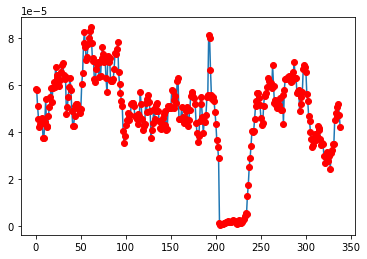

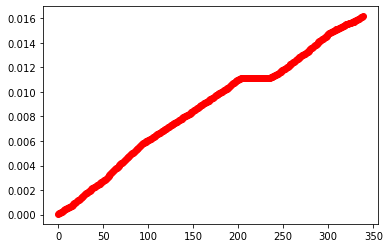

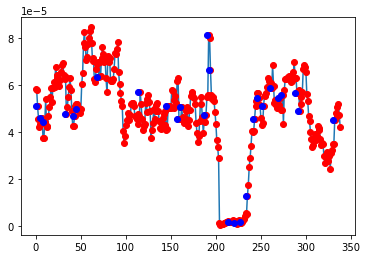

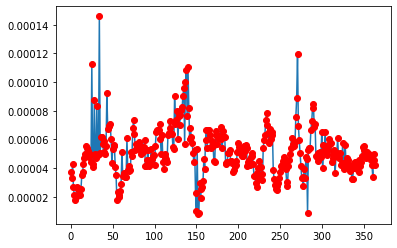

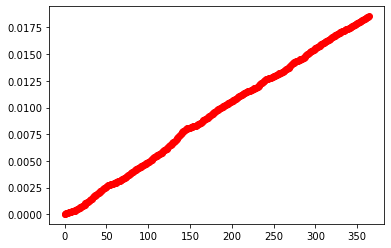

In [56]:
def CheckNormSize(x, y):
    plt.plot(x)
    plt.plot(x, 'ro')
    plt.plot(y, 'bo')
    plt.show()

def CheckNormSize_x(x):
    plt.plot(x)
    plt.plot(x, 'ro')
    plt.show()

def ChangeList(norm_list,index):
    change_list = []
    for norm in norm_list:
        change_list.append(norm[index])
    return change_list

def CheckError(norm_list, ERROR_CONSTANT):
    Check_norm_list = []
    tmp_list = []

    for norm in norm_list:
        tmp_list.append(norm)
        if len(tmp_list) > 2:
            current_tilt = abs(tmp_list[len(tmp_list)-2][1] - tmp_list[len(tmp_list)-1][1])
            provious_tilt = abs(tmp_list[len(tmp_list)-3][1]- tmp_list[len(tmp_list)-2][1])

            is_error = current_tilt >= provious_tilt * ERROR_CONSTANT

            if is_error:
                Check_norm_list.append(norm[1])
            else :
                Check_norm_list.append(np.nan)
    return Check_norm_list

ERROR_CONSTANT = 10
CheckNormSize_x(ChangeList(kyoung_norm,1))
CheckNormSize_x(kyoung_norm_change)
CheckNormSize(ChangeList(kyoung_norm,1),CheckError(kyoung_norm,ERROR_CONSTANT))
# CheckNormSize(CheckNormSize_x(kyoung_norm_change),CheckError(kyoung_norm_change,ERROR_CONSTANT))

CheckNormSize_x(ChangeList(joung_norm,1))
CheckNormSize_x(joung_norm_change)
CheckNormSize(ChangeList(joung_norm,1),CheckError(joung_norm,ERROR_CONSTANT))